<h1> Batch Dimensions and Visualization </h1>

0 : torch.Size([5, 40, 64, 64])
1 : torch.Size([5, 40, 64, 64])
2 : torch.Size([5, 40, 64, 64])
3 : torch.Size([5, 40, 64, 64])
4 : torch.Size([4, 40, 64, 64])


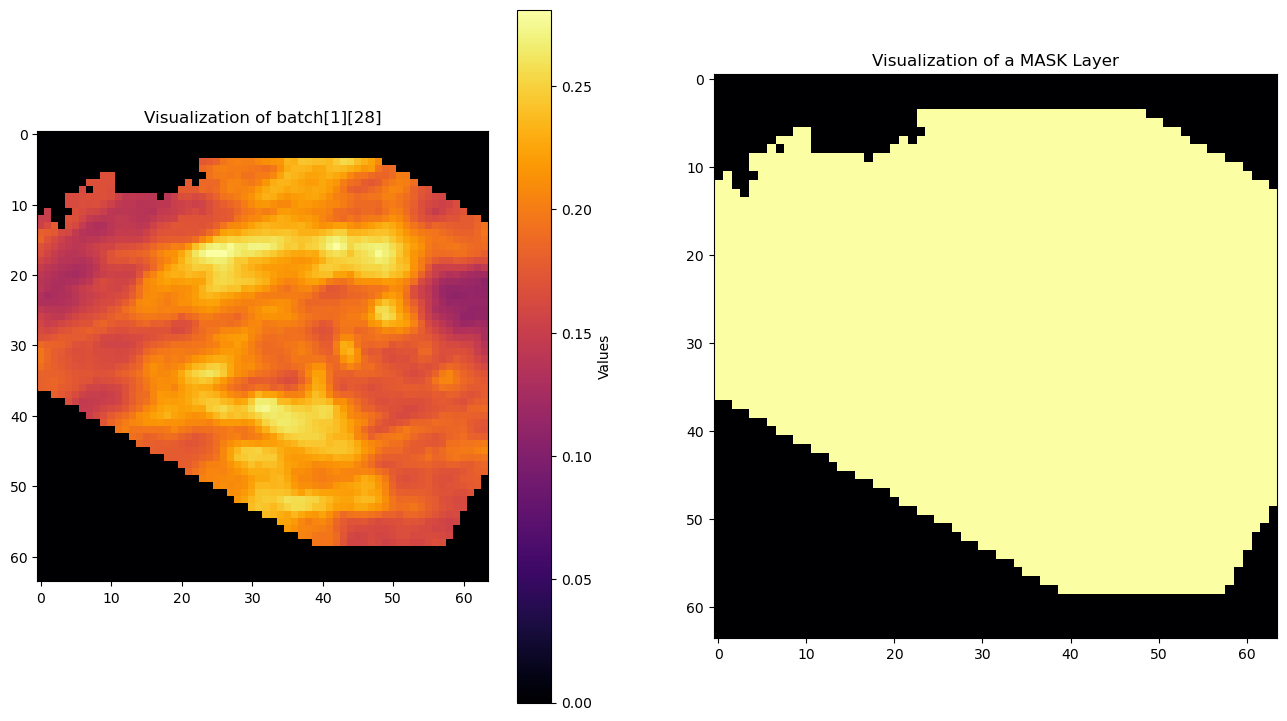

In [13]:
import matplotlib.pyplot as plt
import torch
from utils import TrajectoryDataset
from torch.utils.data import DataLoader
from pathlib import Path

PATH = Path('.')
window= 10
batch_size = 5


trainset = TrajectoryDataset(PATH / 'data/train.h5', window=window, flatten=True)
validset = TrajectoryDataset(PATH / 'data/valid.h5', window=window, flatten=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)

plot_batch = None
for i, (batch, _) in  enumerate(trainloader):
    print(f"{i} : {batch.shape}")
    plot_batch = batch



# Plot
# Choose random batch[i,j, :, :]
i = torch.randint(0,4,(1,))
j = torch.randint(0,40, (1,))
if (j+1) % 4 == 0 and j != 0:
    j = j -1

figure, axis = plt.subplots(1,2, figsize=(16,9))
im = axis[0].imshow(batch[i[0],j[0]],  cmap='inferno')
axis[0].set_title(f"Visualization of batch[{i[0]}][{j[0]}]")
figure.colorbar(mappable = im,label='Values')
axis[1].imshow(batch[0,7],  cmap='inferno')
axis[1].set_title(f"Visualization of a MASK Layer")

plt.show()


<h1> Understand UNET dimensions </h1>

In [14]:

import torch
import torch.nn as nn
from nn import UNet

in_channels = 4
out_channels = 4
mod_features = 66
hidden_channels = [32, 64, 128]
hidden_blocks = [2, 3, 5]
spatial = 2

# UNET Forward : x (B, C, H, W)
unet = UNet(
    in_channels=in_channels,
    out_channels=out_channels,
    mod_features=mod_features,
    hidden_channels=hidden_channels,
    hidden_blocks=hidden_blocks,
    spatial=spatial,
)


batch_size = 4
x = torch.randn(batch_size, in_channels, 128, 128)


y = torch.randn(batch_size, mod_features)


output = unet(x, y)


print(output.shape)

torch.Size([4, 4, 128, 128])


<h1> Understand ScoreUNET dimensions </h1>

In [15]:
import torch
import torch.nn as nn
from score import ScoreUNet
batch_size = 5
MAR_channels = 4 # Example ['RF', 'T2m', 'U10m', MASK]
window = 10
y_dim = 128
x_dim = 128

CONFIG = { 'hidden_channels' : [32, 64, 128],  \
'hidden_blocks' : [2, 3, 5],  \
'spatial' : 2, \
'channels' : window*MAR_channels, \
'context' : 0,\
'embedding' : 64 }


score_unet = ScoreUNet(**CONFIG)




x = torch.randn([batch_size, window*MAR_channels, y_dim, x_dim]) # because of flatten
t = torch.rand(x.shape[0], dtype=x.dtype, device=x.device)

print(f"x:  {x.shape} , t: {t.shape}")
c = None


output = score_unet(x, t, c)


print(f"Output Shape : {output.shape}")

x:  torch.Size([5, 40, 128, 128]) , t: torch.Size([5])
Output Shape : torch.Size([5, 40, 128, 128])


<h1> Understand VPSDE dimensions </h1>

In [16]:
import torch
import torch.nn as nn
from score import ScoreUNet, VPSDE

batch_size = 5
MAR_channels = 4 # Example ['RF', 'T2m', 'U10m', MASK]
window = 10
y_dim = 128
x_dim = 128

CONFIG = { 'hidden_channels' : [32, 64, 128],  \
'hidden_blocks' : [2, 3, 5],  \
'spatial' : 2, \
'channels' : window*MAR_channels, \
'context' : 0,\
'embedding' : 64,\
}


score_unet = ScoreUNet(**CONFIG)
vpsde = VPSDE(score_unet, shape=(MAR_channels*window, y_dim, x_dim))



x = torch.randn([batch_size, window*MAR_channels, y_dim, x_dim]) # window*MAR_channels because of flatten

vpsde.loss(x)

tensor(1.2994, grad_fn=<MeanBackward0>)

<h1> Batch Loop (Ensure Architecture design is well shaped)</h1>

In [17]:
import torch
import h5py
import torch.nn as nn
from score import ScoreUNet, VPSDE

# Common dimensions
batch_size = 5
MAR_channels = 4 # Example ['RF', 'T2m', 'U10m', MASK]
window = 10
y_dim = 128
x_dim = 128

# Define the network
CONFIG = { 'hidden_channels' : [32, 64, 128],  \
'hidden_blocks' : [2, 3, 5],  \
'spatial' : 2, \
'channels' : window*MAR_channels, \
'context' : 0,\
'embedding' : 64 }

# Denoiser and Scheduler
score_unet = ScoreUNet(**CONFIG)
vpsde = VPSDE(score_unet, shape=(MAR_channels*window, y_dim, x_dim))

trainset = TrajectoryDataset(PATH / "data/train.h5", window=10, flatten=True)
validset = TrajectoryDataset(PATH / "data/valid.h5", window=10, flatten=True)

'''
 Batch loop
'''
with h5py.File(PATH / "data/mask.h5", "r") as f:
    mask = torch.tensor(f["dataset"][:], dtype=torch.float32).unsqueeze(0)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=1, persistent_workers=True)
for i, (batch, _) in enumerate(trainloader):
        loss = vpsde.loss(batch, w=mask)
        print(f"{i} batch : {batch.shape}, loss : {loss}")

0 batch : torch.Size([5, 40, 64, 64]), loss : 1.2517942190170288
1 batch : torch.Size([5, 40, 64, 64]), loss : 1.2469114065170288
2 batch : torch.Size([5, 40, 64, 64]), loss : 1.2365354299545288
3 batch : torch.Size([5, 40, 64, 64]), loss : 1.2249854803085327
4 batch : torch.Size([4, 40, 64, 64]), loss : 1.2477240562438965


<h1> CPU Training Loop </h1>

In [10]:
import os
import h5py
import math
import torch
import numpy as np
#import wandb
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import trange
from pathlib import Path
from utils import TrajectoryDataset
from score import ScoreUNet, MCScoreWrapper, VPSDE
from score import VPSDE

PATH = Path('.')

with h5py.File(PATH / "data/mask.h5", "r") as f:
    mask = torch.tensor(f["dataset"][:], dtype=torch.float32).unsqueeze(0)

if torch.isnan(mask).any():
    raise ValueError("Mask contains NaN values!")

TRAIN_CONFIG = {
    "epochs": 100,
    "batch_size": 5,
    "learning_rate": 1e-3,
    "weight_decay": 1e-3,
    "scheduler": "linear",
    "embedding": 32,
    "hidden_channels": (64,),
    "hidden_blocks": (3,),
    "activation": "SiLU",
}
device = 'cpu'

'''
Definition of Denoiser and Scheduler
'''
# Common dimensions
batch_size = 5
MAR_channels = 4 # Example ['RF', 'T2m', 'U10m', MASK]
window = 10
y_dim = 128
x_dim = 128

MODEL_CONFIG = { 'hidden_channels' : [32, 64, 128],  \
'hidden_blocks' : [2, 3, 5],  \
'spatial' : 2, \
'channels' : window*MAR_channels, \
'context' : 0,\
'embedding' : 64 }

# Denoiser and Scheduler
score_unet = ScoreUNet(**MODEL_CONFIG)
vpsde = VPSDE(score_unet, shape=(MAR_channels*window, y_dim, x_dim))

# Load Dataset
trainset = TrajectoryDataset(PATH / "data/train.h5", window=10, flatten=True)
validset = TrajectoryDataset(PATH / "data/valid.h5", window=10, flatten=True)

trainloader = DataLoader(trainset, batch_size=TRAIN_CONFIG["batch_size"], shuffle=True, num_workers=1, persistent_workers=True)
validloader = DataLoader(validset, batch_size=TRAIN_CONFIG["batch_size"], shuffle=False, num_workers=1, persistent_workers=True)


optimizer = optim.AdamW(vpsde.parameters(), lr=TRAIN_CONFIG["learning_rate"], weight_decay=TRAIN_CONFIG["weight_decay"])

# Define Learning Rate Scheduler
if TRAIN_CONFIG["scheduler"] == "linear":
    lr_lambda = lambda t: 1 - (t / TRAIN_CONFIG["epochs"])
elif TRAIN_CONFIG["scheduler"] == "cosine":
    lr_lambda = lambda t: (1 + math.cos(math.pi * t / TRAIN_CONFIG["epochs"])) / 2
elif TRAIN_CONFIG["scheduler"] == "exponential":
    lr_lambda = lambda t: math.exp(-7 * (t / TRAIN_CONFIG["epochs"]) ** 2)
else:
    raise ValueError("Invalid scheduler type")

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

all_losses_train = []
all_losses_valid = []
for epoch in (bar := trange(TRAIN_CONFIG["epochs"], ncols=88)):
    losses_train = []
    losses_valid = []

    # Training
    vpsde.train()
    for i, (batch, _) in enumerate(trainloader):
        if torch.isnan(batch).any():
            raise ValueError("batch contains NaN values!")
        batch = batch.to(device)
        optimizer.zero_grad()

        # Mask
        mask_batch = mask.to(device).expand_as(batch)
        w = mask_batch.float()


        loss = vpsde.loss(batch, w=w)
        loss.backward()
        optimizer.step()

        losses_train.append(loss.detach())

    # Evaluation
    vpsde.eval()
    with torch.no_grad():
        for batch, _ in validloader:
            batch = batch.to(device)
            mask_batch = mask.to(device).expand_as(batch)
            w = mask_batch.float()

            loss = vpsde.loss(batch, w=w)
            losses_valid.append(loss)

    loss_train = torch.stack(losses_train).mean().item()
    loss_valid = torch.stack(losses_valid).mean().item()
    print(f"Train Loss : {loss_train}, Valid Loss : {loss_valid}")
    lr = optimizer.param_groups[0]['lr']

    all_losses_train.append(loss_train)
    all_losses_valid.append(loss_valid)

    scheduler.step()

  1%|▌                                                  | 1/100 [00:02<04:05,  2.47s/it]

Train Loss : 1.275356411933899, Valid Loss : 1.0680029392242432


  2%|█                                                  | 2/100 [00:04<03:39,  2.24s/it]

Train Loss : 1.0513733625411987, Valid Loss : 1.0271481275558472


  3%|█▌                                                 | 3/100 [00:05<02:59,  1.85s/it]

Train Loss : 1.0041062831878662, Valid Loss : 0.9741513133049011


  4%|██                                                 | 4/100 [00:07<02:40,  1.67s/it]

Train Loss : 0.961264967918396, Valid Loss : 0.9404802322387695


  5%|██▌                                                | 5/100 [00:08<02:30,  1.58s/it]

Train Loss : 0.929101824760437, Valid Loss : 0.9357950687408447


  6%|███                                                | 6/100 [00:10<02:27,  1.57s/it]

Train Loss : 0.8948909640312195, Valid Loss : 0.8752454519271851


  7%|███▌                                               | 7/100 [00:11<02:20,  1.51s/it]

Train Loss : 0.8735884428024292, Valid Loss : 0.8159571886062622


  8%|████                                               | 8/100 [00:13<02:25,  1.58s/it]

Train Loss : 0.8151341676712036, Valid Loss : 0.7714217305183411


  9%|████▌                                              | 9/100 [00:15<02:29,  1.65s/it]

Train Loss : 0.7954951524734497, Valid Loss : 0.7708290815353394


 10%|█████                                             | 10/100 [00:16<02:24,  1.60s/it]

Train Loss : 0.7673574686050415, Valid Loss : 0.887787938117981


 11%|█████▌                                            | 11/100 [00:18<02:17,  1.54s/it]

Train Loss : 0.7454774975776672, Valid Loss : 0.7336677312850952


 12%|██████                                            | 12/100 [00:19<02:13,  1.51s/it]

Train Loss : 0.7844304442405701, Valid Loss : 0.6749305129051208


 13%|██████▌                                           | 13/100 [00:21<02:22,  1.64s/it]

Train Loss : 0.6960731744766235, Valid Loss : 0.6962841153144836


 14%|███████                                           | 14/100 [00:22<02:16,  1.58s/it]

Train Loss : 0.6874629855155945, Valid Loss : 0.6589747667312622


 15%|███████▌                                          | 15/100 [00:24<02:11,  1.55s/it]

Train Loss : 0.6800795793533325, Valid Loss : 0.654292106628418


 16%|████████                                          | 16/100 [00:26<02:13,  1.59s/it]

Train Loss : 0.6799415349960327, Valid Loss : 0.6184617877006531


 17%|████████▌                                         | 17/100 [00:27<02:17,  1.65s/it]

Train Loss : 0.630203127861023, Valid Loss : 0.6794664263725281


 18%|█████████                                         | 18/100 [00:29<02:10,  1.59s/it]

Train Loss : 0.6214379668235779, Valid Loss : 0.5689373016357422


 19%|█████████▌                                        | 19/100 [00:30<02:05,  1.55s/it]

Train Loss : 0.6520164608955383, Valid Loss : 0.6084885001182556


 20%|██████████                                        | 20/100 [00:32<02:02,  1.54s/it]

Train Loss : 0.5972301959991455, Valid Loss : 0.5451580286026001


 21%|██████████▌                                       | 21/100 [00:33<02:03,  1.56s/it]

Train Loss : 0.6311159133911133, Valid Loss : 0.6182120442390442


 22%|███████████                                       | 22/100 [00:35<01:56,  1.50s/it]

Train Loss : 0.5794421434402466, Valid Loss : 0.5265606641769409


 23%|███████████▌                                      | 23/100 [00:36<01:52,  1.46s/it]

Train Loss : 0.5962375402450562, Valid Loss : 0.5910342335700989


 24%|████████████                                      | 24/100 [00:38<02:00,  1.58s/it]

Train Loss : 0.5456579923629761, Valid Loss : 0.6756755113601685


 25%|████████████▌                                     | 25/100 [00:40<02:02,  1.63s/it]

Train Loss : 0.5622488856315613, Valid Loss : 0.6252255439758301


 26%|█████████████                                     | 26/100 [00:41<01:54,  1.55s/it]

Train Loss : 0.5736935138702393, Valid Loss : 0.5166386365890503


 27%|█████████████▌                                    | 27/100 [00:42<01:48,  1.49s/it]

Train Loss : 0.5317924618721008, Valid Loss : 0.5206257104873657


 28%|██████████████                                    | 28/100 [00:44<01:45,  1.46s/it]

Train Loss : 0.5601599216461182, Valid Loss : 0.472868949174881


 29%|██████████████▍                                   | 29/100 [00:46<01:52,  1.58s/it]

Train Loss : 0.5413051843643188, Valid Loss : 0.4628385603427887


 30%|███████████████                                   | 30/100 [00:47<01:50,  1.58s/it]

Train Loss : 0.5352426767349243, Valid Loss : 0.45648348331451416


 31%|███████████████▌                                  | 31/100 [00:49<01:45,  1.52s/it]

Train Loss : 0.576348602771759, Valid Loss : 0.5159358978271484


 32%|████████████████                                  | 32/100 [00:50<01:42,  1.51s/it]

Train Loss : 0.5095683932304382, Valid Loss : 0.4519828259944916


 33%|████████████████▌                                 | 33/100 [00:52<01:37,  1.46s/it]

Train Loss : 0.5290473699569702, Valid Loss : 0.4531722664833069


 34%|█████████████████                                 | 34/100 [00:53<01:34,  1.43s/it]

Train Loss : 0.4804733693599701, Valid Loss : 0.4471297562122345


 35%|█████████████████▌                                | 35/100 [00:54<01:31,  1.40s/it]

Train Loss : 0.5020641088485718, Valid Loss : 0.4380612373352051


 36%|██████████████████                                | 36/100 [00:56<01:37,  1.53s/it]

Train Loss : 0.45532065629959106, Valid Loss : 0.4203374683856964


 37%|██████████████████▌                               | 37/100 [00:57<01:34,  1.49s/it]

Train Loss : 0.4460477828979492, Valid Loss : 0.45070791244506836


 38%|███████████████████                               | 38/100 [00:59<01:33,  1.50s/it]

Train Loss : 0.4926609396934509, Valid Loss : 0.4725750982761383


 39%|███████████████████▌                              | 39/100 [01:01<01:33,  1.54s/it]

Train Loss : 0.5263298153877258, Valid Loss : 0.44405898451805115


 40%|████████████████████                              | 40/100 [01:02<01:33,  1.57s/it]

Train Loss : 0.4231279492378235, Valid Loss : 0.7064822316169739


 41%|████████████████████▌                             | 41/100 [01:04<01:29,  1.52s/it]

Train Loss : 0.4583436846733093, Valid Loss : 0.5108821988105774


 42%|█████████████████████                             | 42/100 [01:05<01:26,  1.48s/it]

Train Loss : 0.4793831706047058, Valid Loss : 0.4409601390361786


 43%|█████████████████████▌                            | 43/100 [01:06<01:22,  1.45s/it]

Train Loss : 0.4821094870567322, Valid Loss : 0.4869905412197113


 44%|██████████████████████                            | 44/100 [01:08<01:20,  1.44s/it]

Train Loss : 0.4387187957763672, Valid Loss : 0.39591145515441895


 45%|██████████████████████▌                           | 45/100 [01:09<01:18,  1.43s/it]

Train Loss : 0.4908124506473541, Valid Loss : 0.41626065969467163


 46%|███████████████████████                           | 46/100 [01:11<01:15,  1.40s/it]

Train Loss : 0.4738197326660156, Valid Loss : 0.3778773248195648


 47%|███████████████████████▌                          | 47/100 [01:12<01:13,  1.40s/it]

Train Loss : 0.4160148501396179, Valid Loss : 0.37600380182266235


 48%|████████████████████████                          | 48/100 [01:13<01:13,  1.42s/it]

Train Loss : 0.4243016839027405, Valid Loss : 0.4742957353591919


 49%|████████████████████████▌                         | 49/100 [01:15<01:18,  1.54s/it]

Train Loss : 0.4221138060092926, Valid Loss : 0.5168087482452393


 50%|█████████████████████████                         | 50/100 [01:17<01:21,  1.63s/it]

Train Loss : 0.4420905113220215, Valid Loss : 0.3957407474517822


 51%|█████████████████████████▌                        | 51/100 [01:19<01:19,  1.61s/it]

Train Loss : 0.36533236503601074, Valid Loss : 0.3565559983253479


 52%|██████████████████████████                        | 52/100 [01:20<01:14,  1.54s/it]

Train Loss : 0.3909708559513092, Valid Loss : 0.3563288748264313


 53%|██████████████████████████▌                       | 53/100 [01:21<01:10,  1.49s/it]

Train Loss : 0.40944766998291016, Valid Loss : 0.36606183648109436


 54%|███████████████████████████                       | 54/100 [01:23<01:07,  1.47s/it]

Train Loss : 0.3999341130256653, Valid Loss : 0.4506058394908905


 55%|███████████████████████████▌                      | 55/100 [01:24<01:07,  1.49s/it]

Train Loss : 0.46191567182540894, Valid Loss : 0.5409741401672363


 56%|████████████████████████████                      | 56/100 [01:26<01:08,  1.55s/it]

Train Loss : 0.39015430212020874, Valid Loss : 0.3438038229942322


 57%|████████████████████████████▍                     | 57/100 [01:27<01:04,  1.49s/it]

Train Loss : 0.3745175898075104, Valid Loss : 0.38086405396461487


 58%|████████████████████████████▉                     | 58/100 [01:29<01:00,  1.45s/it]

Train Loss : 0.4498100280761719, Valid Loss : 0.35374873876571655


 59%|█████████████████████████████▌                    | 59/100 [01:30<00:58,  1.43s/it]

Train Loss : 0.37413933873176575, Valid Loss : 0.33974435925483704


 60%|██████████████████████████████                    | 60/100 [01:32<00:56,  1.42s/it]

Train Loss : 0.3669227361679077, Valid Loss : 0.4058816730976105


 61%|██████████████████████████████▌                   | 61/100 [01:33<00:57,  1.49s/it]

Train Loss : 0.39049968123435974, Valid Loss : 0.32744455337524414


 62%|███████████████████████████████                   | 62/100 [01:35<00:55,  1.45s/it]

Train Loss : 0.43287205696105957, Valid Loss : 0.38243165612220764


 63%|███████████████████████████████▌                  | 63/100 [01:36<00:58,  1.57s/it]

Train Loss : 0.39094632863998413, Valid Loss : 0.3797464966773987


 64%|████████████████████████████████                  | 64/100 [01:38<00:58,  1.63s/it]

Train Loss : 0.3376789093017578, Valid Loss : 0.32514387369155884


 65%|████████████████████████████████▌                 | 65/100 [01:40<00:54,  1.56s/it]

Train Loss : 0.3823398947715759, Valid Loss : 0.3221382796764374


 66%|█████████████████████████████████                 | 66/100 [01:41<00:51,  1.50s/it]

Train Loss : 0.35433855652809143, Valid Loss : 0.3208428919315338


 67%|█████████████████████████████████▌                | 67/100 [01:42<00:48,  1.46s/it]

Train Loss : 0.3377305269241333, Valid Loss : 0.3299904763698578


 68%|██████████████████████████████████                | 68/100 [01:44<00:47,  1.48s/it]

Train Loss : 0.34399038553237915, Valid Loss : 0.31591662764549255


 69%|██████████████████████████████████▌               | 69/100 [01:45<00:44,  1.44s/it]

Train Loss : 0.39792734384536743, Valid Loss : 0.3194259703159332


 70%|███████████████████████████████████               | 70/100 [01:47<00:42,  1.42s/it]

Train Loss : 0.33707815408706665, Valid Loss : 0.5238550305366516


 71%|███████████████████████████████████▌              | 71/100 [01:48<00:42,  1.46s/it]

Train Loss : 0.3894820809364319, Valid Loss : 0.35703566670417786


 72%|████████████████████████████████████              | 72/100 [01:50<00:42,  1.52s/it]

Train Loss : 0.3585663437843323, Valid Loss : 0.31703588366508484


 73%|████████████████████████████████████▌             | 73/100 [01:51<00:39,  1.47s/it]

Train Loss : 0.35221046209335327, Valid Loss : 0.3172887861728668


 74%|█████████████████████████████████████             | 74/100 [01:53<00:41,  1.59s/it]

Train Loss : 0.41857796907424927, Valid Loss : 0.3079594075679779


 75%|█████████████████████████████████████▌            | 75/100 [01:55<00:39,  1.58s/it]

Train Loss : 0.36583876609802246, Valid Loss : 0.46354755759239197


 76%|██████████████████████████████████████            | 76/100 [01:56<00:37,  1.58s/it]

Train Loss : 0.46092361211776733, Valid Loss : 0.3262594938278198


 77%|██████████████████████████████████████▌           | 77/100 [01:58<00:34,  1.52s/it]

Train Loss : 0.38462844491004944, Valid Loss : 0.30489668250083923


 78%|███████████████████████████████████████           | 78/100 [01:59<00:32,  1.48s/it]

Train Loss : 0.3471453785896301, Valid Loss : 0.3607341945171356


 79%|███████████████████████████████████████▌          | 79/100 [02:01<00:33,  1.60s/it]

Train Loss : 0.3518122732639313, Valid Loss : 0.3038618266582489


 80%|████████████████████████████████████████          | 80/100 [02:02<00:32,  1.62s/it]

Train Loss : 0.3524598181247711, Valid Loss : 0.32267898321151733


 81%|████████████████████████████████████████▌         | 81/100 [02:04<00:29,  1.54s/it]

Train Loss : 0.35044726729393005, Valid Loss : 0.3437631130218506


 82%|█████████████████████████████████████████         | 82/100 [02:05<00:26,  1.49s/it]

Train Loss : 0.3676268756389618, Valid Loss : 0.42899852991104126


 83%|█████████████████████████████████████████▌        | 83/100 [02:07<00:25,  1.48s/it]

Train Loss : 0.37688717246055603, Valid Loss : 0.3001134395599365


 84%|██████████████████████████████████████████        | 84/100 [02:08<00:23,  1.49s/it]

Train Loss : 0.3567434251308441, Valid Loss : 0.31184232234954834


 85%|██████████████████████████████████████████▌       | 85/100 [02:09<00:21,  1.45s/it]

Train Loss : 0.3238215446472168, Valid Loss : 0.5073044300079346


 86%|███████████████████████████████████████████       | 86/100 [02:11<00:21,  1.53s/it]

Train Loss : 0.3406655788421631, Valid Loss : 0.3088265359401703


 87%|███████████████████████████████████████████▌      | 87/100 [02:13<00:21,  1.63s/it]

Train Loss : 0.34912586212158203, Valid Loss : 0.32320213317871094


 88%|████████████████████████████████████████████      | 88/100 [02:15<00:19,  1.59s/it]

Train Loss : 0.37958887219429016, Valid Loss : 0.3006186783313751


 89%|████████████████████████████████████████████▌     | 89/100 [02:16<00:16,  1.54s/it]

Train Loss : 0.3744262456893921, Valid Loss : 0.4389662444591522


 90%|█████████████████████████████████████████████     | 90/100 [02:17<00:14,  1.49s/it]

Train Loss : 0.3253408968448639, Valid Loss : 0.29293176531791687


 91%|█████████████████████████████████████████████▌    | 91/100 [02:19<00:13,  1.53s/it]

Train Loss : 0.3761608600616455, Valid Loss : 0.29686105251312256


 92%|██████████████████████████████████████████████    | 92/100 [02:20<00:11,  1.48s/it]

Train Loss : 0.3764263689517975, Valid Loss : 0.2923509180545807


 93%|██████████████████████████████████████████████▌   | 93/100 [02:22<00:10,  1.55s/it]

Train Loss : 0.319597065448761, Valid Loss : 0.3431159555912018


 94%|███████████████████████████████████████████████   | 94/100 [02:24<00:09,  1.59s/it]

Train Loss : 0.3148953318595886, Valid Loss : 0.3639202415943146


 95%|███████████████████████████████████████████████▌  | 95/100 [02:25<00:08,  1.63s/it]

Train Loss : 0.3327561318874359, Valid Loss : 0.3926946222782135


 96%|████████████████████████████████████████████████  | 96/100 [02:27<00:06,  1.61s/it]

Train Loss : 0.31870514154434204, Valid Loss : 0.3011385500431061


 97%|████████████████████████████████████████████████▌ | 97/100 [02:29<00:04,  1.62s/it]

Train Loss : 0.3096548914909363, Valid Loss : 0.5356667041778564


 98%|█████████████████████████████████████████████████ | 98/100 [02:30<00:03,  1.56s/it]

Train Loss : 0.36353397369384766, Valid Loss : 0.37568849325180054


 99%|█████████████████████████████████████████████████▌| 99/100 [02:32<00:01,  1.65s/it]

Train Loss : 0.336096853017807, Valid Loss : 0.36304694414138794


100%|█████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.54s/it]

Train Loss : 0.36306247115135193, Valid Loss : 0.29904669523239136


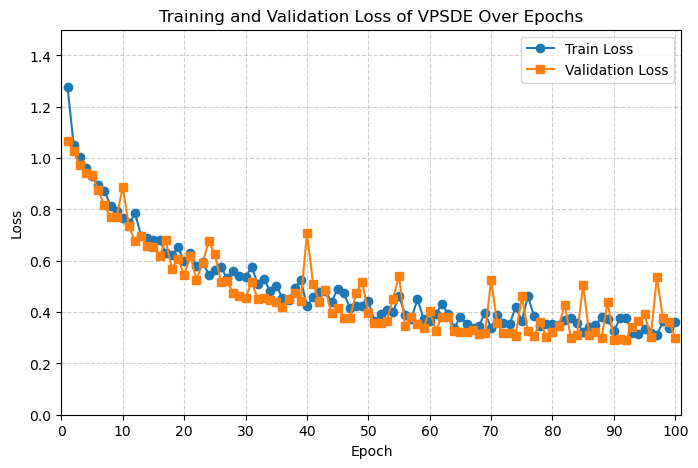

In [11]:
import matplotlib.pyplot as plt


epochs = list(range(1, len(all_losses_train) + 1))


plt.figure(figsize=(8, 5))
plt.plot(epochs, all_losses_train, label="Train Loss", marker="o", linestyle="-")
plt.plot(epochs, all_losses_valid, label="Validation Loss", marker="s", linestyle="-")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss of VPSDE Over Epochs")
plt.ylim(0, 1.5)
plt.xlim(0,101)
plt.xticks(range(0, 101, 10))
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()